Table A-1
         Word Count  Mean Score  Std Dev  Raw Score Variance  \
Story A        2291        83.3    10.57               111.8   
Story B        3832        87.8     6.21                38.6   
Story C        1962        86.1     5.05                25.5   
Story D        1671        86.6     4.99                24.9   
Story E        1998        83.7     6.04                36.5   
Story F        3225        85.4     6.73                45.3   
Story G        3068        85.4     7.82                61.2   
Story H        1279        83.9     5.94                35.2   
Story I        2145        85.2     8.86                78.5   
Story J        1765        80.0     9.53                90.9   

         Z-Score Variance  Range  
Story A              1.05  48–94  
Story B              0.52  66–95  
Story C              0.50  76–97  
Story D              0.51  71–93  
Story E              0.62  66–92  
Story F              0.72  61–95  
Story G              1.26  65–95  
Story

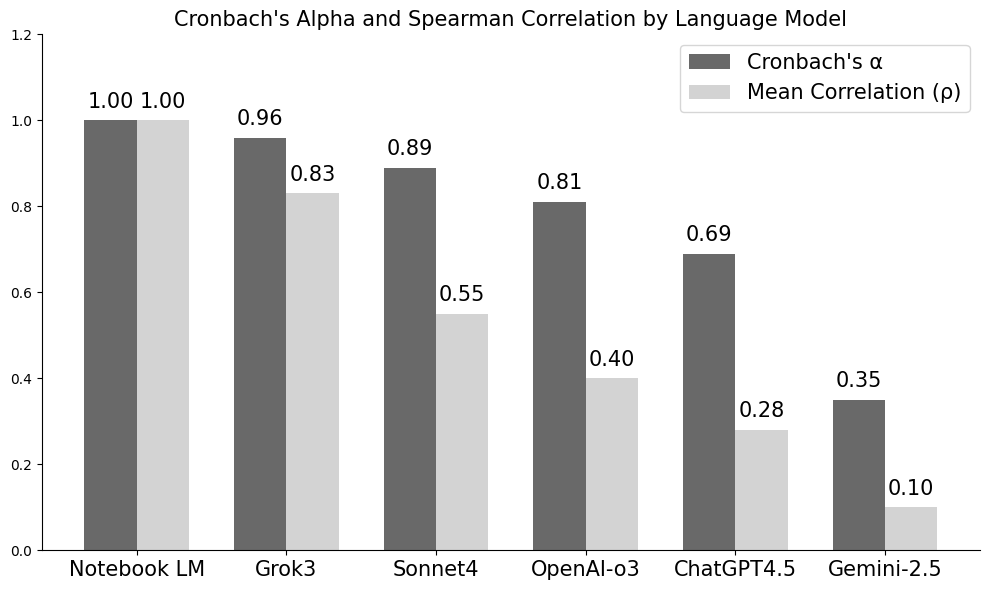

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations

# --- Table A-1: Descriptive Statistics by Story ---

# Load evaluation data
df = pd.read_csv('official_row_data.csv', encoding='utf-8')

# Manually defined word count dictionary
word_counts = {
    'Story A': 2291, 'Story B': 3832, 'Story C': 1962, 'Story D': 1671,
    'Story E': 1998, 'Story F': 3225, 'Story G': 3068, 'Story H': 1279,
    'Story I': 2145, 'Story J': 1765
}

# Calculate z-score within each model-session group
df['z_score'] = df.groupby(['model', 'session'])['score'].transform(
    lambda x: (x - x.mean()) / x.std(ddof=1)
)

# Compute descriptive statistics grouped by story
grouped = df.groupby('story')
summary_df = pd.DataFrame({
    'Word Count': pd.Series(word_counts),
    'Mean Score': grouped['score'].mean().round(1),
    'Std Dev': grouped['score'].std(ddof=1).round(2),
    'Raw Score Variance': grouped['score'].var(ddof=1).round(1),
    'Z-Score Variance': grouped['z_score'].var(ddof=1).round(2),
    'Range': grouped['score'].apply(lambda x: f"{x.min()}–{x.max()}")
})

print("Table A-1")
print(summary_df)


# --- Table A-2: Model-Specific Evaluation Consistency ---

def cronbach_alpha(data):
    """Calculate Cronbach's alpha"""
    n_items, n_sessions = data.shape
    session_var = np.var(data, axis=0, ddof=1)
    total_scores = np.sum(data, axis=1)
    total_var = np.var(total_scores, ddof=1)
    alpha = (n_sessions / (n_sessions - 1)) * (1 - np.sum(session_var) / total_var)
    return alpha

def mean_spearman_correlation(data):
    """Compute mean Spearman correlation across all session pairs"""
    n_sessions = data.shape[1]
    correlations = []
    for i, j in combinations(range(n_sessions), 2):
        corr, _ = stats.spearmanr(data[:, i], data[:, j])
        correlations.append(corr)
    return np.mean(correlations)

models = ['ChatGPT4.5', 'Notebook LM', 'Gemini-2.5', 'Grok3', 'Sonnet4', 'OpenAI-o3']
stories = ['Story A', 'Story B', 'Story C', 'Story D', 'Story E', 'Story F', 'Story G', 'Story H', 'Story I', 'Story J']

results = []

for model in models:
    model_data = df[df['model'] == model]
    pivot = model_data.pivot(index='story', columns='session', values='score')
    matrix = pivot.reindex(stories).values
    alpha = cronbach_alpha(matrix)
    mean_corr = mean_spearman_correlation(matrix)
    results.append({
        'Model': model,
        'Cronbach_alpha': round(alpha, 2),
        'Mean_Correlation': round(mean_corr, 2),
    })

results_df = pd.DataFrame(results).sort_values(by='Cronbach_alpha', ascending=False)

print("\nTable A-2")
print(results_df)


# --- Figure A-1: Bar Plot of Cronbach's Alpha and Spearman Correlation ---

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(results_df))

bars1 = ax.bar(index, results_df['Cronbach_alpha'], bar_width, label='Cronbach\'s α', color='dimgray')
bars2 = ax.bar([i + bar_width for i in index], results_df['Mean_Correlation'], bar_width, label='Mean Correlation (ρ)', color='lightgray')

ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(results_df['Model'], fontsize=15)
ax.set_ylim(0, 1.2)
ax.legend(fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom', fontsize=15)

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom', fontsize=15)

plt.title('Cronbach\'s Alpha and Spearman Correlation by Language Model', fontsize=15)
plt.tight_layout()

print("\nFigure A-1")
plt.show()
